In [1]:
import torch
from torch import nn
from torch import optim
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from collections import defaultdict
import os
import glob
import random

## Configuration

In [2]:
# Number of force cells in the robotic leg
N_CELLS = 8

# Directory where the derived data is stored
DERIVED_DATA_DIR = '../../../../data'

# Percentage of the date for the test set
TEST_SIZE = 0.3

TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', TORCH_DEVICE)

Using device: cuda


## Load data

In [ ]:
exp_path = glob.glob(DERIVED_DATA_DIR + '/*/*')[0]
exp_path

In [ ]:
H3_LEG = 'L' # L|R

# features = [H3_LEG + a + m for a in ['Hip', 'Knee', 'Ankle'] for m in ['Pos', 'Vel', 'Acc', 'Torque']] + ['LegKnee{}Filtered'.format(m) for m in ['Position', 'Velocity', 'Torque']]
features = [H3_LEG + a + m for a in ['Hip', 'Knee'] for m in ['Pos', 'Torque']]
targets = ['F3z'] #['F' + str(i + 1) + ax for i in range(N_CELLS) for ax in ['x', 'y', 'z']]

print('Number of features: {}'.format(len(features)))
print('Selected features: {}'.format(features))
print('\n')
print('Number of targets: {}'.format(len(targets)))
print('Selected targets: {}'.format(targets))

In [ ]:
# Load targets
targets_df = pd.read_csv(exp_path + '/force_cells_processed.csv')

# Load features
exo_df = pd.read_csv(exp_path + '/H3_processed.csv')
# leg_df = pd.read_csv(exp_path + '/leg_processed.csv')
# features_df = pd.concat([exo_df, leg_df], axis=1)
features_df = exo_df

idx_aux = targets_df.duplicated(keep='first')
targets_df = targets_df.loc[~idx_aux]
features_df = features_df.loc[~idx_aux]
print('Droping {} duplicated data points'.format(len(idx_aux[idx_aux == False])))

# Drop first row to remove noise in the start of the data recording
targets_df = targets_df.iloc[1:]
features_df = features_df.iloc[1:]
# Drop null values
idx = features_df.notna().all(axis=1)
features_df = features_df.loc[idx]
targets_df = targets_df.loc[idx]
print('Droping {} data points by null features'.format(len(idx[idx == False])))

assert(len(features_df) == len(targets_df))
# Store the final array
targets_arr = targets_df[targets].values
features_arr = features_df[features].values

print('X: {}, Y: {} \n'.format(features_arr.shape, targets_arr.shape))

In [ ]:
idx_split = int(targets_arr.shape[0] * (1 - TEST_SIZE))

X_train = features_arr[:idx_split, :]
X_test = features_arr[idx_split:, :]

Y_train = targets_arr[:idx_split, :]
Y_test = targets_arr[idx_split:, :]

print('Train -> X: {}, Y: {}'.format(X_train.shape, Y_train.shape))
print('Test -> X: {}, Y: {}'.format(X_test.shape, Y_test.shape))

In [ ]:
s = MinMaxScaler().fit(X_train)

X_train_norm = s.transform(X_train)
X_test_norm = s.transform(X_test)

print('Train -> \n min: {}, \n max: {}, \n mean: {}, \n std: {}\n'.format(np.min(X_train_norm, axis=0), np.max(X_train_norm, axis=0), np.mean(X_train_norm, axis=0), np.std(X_train_norm, axis=0)))
print('Test -> \n min: {}, \n max: {}, \n mean: {}, \n std: {}\n'.format(np.min(X_test_norm, axis=0), np.max(X_test_norm, axis=0), np.mean(X_test_norm, axis=0), np.std(X_test_norm, axis=0)))

In [ ]:
SEQUENCE_LEN = 5
    
splits = [i for i in range(0, X_train_norm.shape[0], SEQUENCE_LEN)]

X_train_norm_tensor = np.zeros([len(splits), SEQUENCE_LEN, len(features)])
Y_train_tensor = np.zeros([len(splits), SEQUENCE_LEN, len(targets)])
    
for idx, i in enumerate(splits[:-1]):
    X_train_norm_tensor[idx, :, :] = X_train_norm[splits[idx]:splits[idx + 1], :]
    Y_train_tensor[idx, :, :] = Y_train[splits[idx + 1] - 1, :]
        
print(X_train_norm_tensor.shape)
print(Y_train_tensor.shape)

In [ ]:
splits = [i for i in range(0, X_test_norm.shape[0], SEQUENCE_LEN)]

X_test_norm_tensor = np.zeros([len(splits), SEQUENCE_LEN, len(features)])
Y_test_tensor = np.zeros([len(splits), SEQUENCE_LEN, len(targets)])
    
for idx, i in enumerate(splits[:-1]):
    X_test_norm_tensor[idx, :, :] = X_test_norm[splits[idx]:splits[idx + 1], :]
    Y_test_tensor[idx, :, :] = Y_test[splits[idx + 1] - 1, :]
        
print(X_test_norm_tensor.shape)
print(Y_test_tensor.shape)

## Recurrent Neural Network (LSTM)

In [3]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_dim, sigma, output_size, sequence_length, num_iter, n_layers, device, lr=0.001, batch_size=16):
        
        # input size -> Dimension of the input signal
        # outpusize -> Dimension of the output signal
        # hidden_dim -> Dimension of the rnn state
        # n_layers -> If >1, we are using a stacked RNN
        
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.input_size = input_size
        self.sigma = sigma
        self.output_size = output_size
        self.sequence_length = sequence_length
        self.num_layers = n_layers
        
        # define an LSTM with specified parameters
        # batch_first=True means that the first dimension of the input will be the batch_size
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True, dropout=0.3)
        
        # last, fully-connected layer
        self.fc1 = nn.Linear(hidden_dim, output_size) # YOUR CODE HERE

        
        self.lr = lr #Learning Rate
        self.batch_size = batch_size
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.num_iter = num_iter
        self.criterion = nn.MSELoss() #YOUR CODE HERE     
        
        self.device = device
        self.to(self.device)
        
        # A list to store the loss evolution along training
        self.loss_during_training = [] 
        self.valid_loss_during_training = []
        
    def forward(self, x, h0=None):
        
        '''
        About the shape of the different tensors ...:
        
        - Input signal x has shape (batch_size, seq_length, input_size)
        - The initialization of the RNN hidden state h0 has shape (n_layers, batch_size, hidden_dim).
          If None value is used, internally it is initialized to zeros.
        - The RNN output (batch_size, seq_length, hidden_size). This output is the RNN state along time  

        '''
        batch_size = x.size(0) # Number of signals N
        seq_length = x.size(1) # T
        
        # get RNN outputs
        # r_out is the sequence of states
        # hidden is just the last state (we will use it for forecasting)
        #print(x.shape)
        r_out, hidden = self.rnn(x, h0)
        #print(r_out.shape, hidden.shape)
        
        # shape r_out to be (seq_length, hidden_dim) #UNDERSTANDING THIS POINT IS IMPORTANT!!        
        r_out = r_out.reshape(-1, self.hidden_dim) 
        #print(r_out.shape)
        
        output = self.fc1(r_out)
        #print(output.shape)
        
        noise = torch.randn_like(output) * self.sigma
        
        output += noise
        
        # reshape back to temporal structure
        output = output.reshape([-1, self.sequence_length, 1])

        return output, hidden
           
    def trainloop(self, x, y, x_val=None, y_val=None):
        
        # SGD Loop
        for e in range(int(self.num_iter)):
        
            running_loss = 0.
            
            idx = list(range(x.shape[0]))
            random.shuffle(idx)
            
            batchs = [idx[i:i + self.batch_size] for i in range(0, x.shape[0], self.batch_size)]
            for b in batchs:

                features = x[b, :, :]
                target = y[b, :, :]

                # print(features.shape, target.shape)
                self.optim.zero_grad() 
                
                features = torch.Tensor(features).to(self.device) #YOUR CODE HERE  
                target = torch.Tensor(target).to(self.device) #YOUR CODE HERE  
                
                out,hid = self.forward(features)

                # print(out.shape, hid.shape, target.shape)
                # print(out[:, -1, 0].size(), target[:, 0].size())
                loss = self.criterion(out[:, -1, 0], target[:, -1, 0]) #YOUR CODE HERE
                running_loss += loss.item()

                loss.backward()

                # This code helps to avoid vanishing exploiting gradients in RNNs
                # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)

                self.optim.step()
                
            self.loss_during_training.append(running_loss / len(batchs))
            
            if x_val is not None and y_val is not None:
                with torch.no_grad():
                    # Set the model in evaluation mode 
                    self.eval()

                    running_loss_val = 0.
                    idx = list(range(x_val.shape[0]))

                    batchs = [idx[i:i + self.batch_size] for i in range(0, x_val.shape[0], self.batch_size)]
                    for b in batchs:
                        features = x_val[b, :, :]
                        target = y_val[b, :, :]

                        features = torch.Tensor(features).to(self.device) #YOUR CODE HERE  
                        target = torch.Tensor(target).to(self.device) #YOUR CODE HERE  

                        out,hid = self.forward(features)

                        # print(out.shape, hid.shape, target.shape)
                        # print(out[:, -1, 0].size(), target[:, -1, 0].size())
                        loss = self.criterion(out[:, -1, 0], target[:, -1, 0]) #YOUR CODE HERE
                        running_loss_val += loss.item()

                    self.valid_loss_during_training.append(running_loss_val / len(splits))

                # Return the model to training mode
                self.train()

                if(e % 1 == 0):
                    print("%d epochs -> Train loss: %f - Val loss: %f"%(e, self.loss_during_training[-1], self.valid_loss_during_training[-1]))
                    
            else:
                if(e % 1 == 0):
                    print("%d epochs -> Train loss: %f"%(e, self.loss_during_training[-1]))

                

In [ ]:
model = LSTM(input_size=4, hidden_dim=32, sigma=1, output_size=1, sequence_length=SEQUENCE_LEN, 
            num_iter=200, n_layers=1, device=TORCH_DEVICE)

In [ ]:
model.trainloop(X_train_norm_tensor, Y_train_tensor, X_test_norm_tensor, Y_test_tensor)

In [ ]:
plt.figure(figsize=(20,10))

plt.plot(model.loss_during_training, label='Train')
plt.plot(model.valid_loss_during_training, label='Val')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
true = []
pred = []

for i in range(SEQUENCE_LEN, X_test_norm.shape[0]):
    features_ = torch.Tensor(X_test_norm[np.newaxis, i-SEQUENCE_LEN:i, :]).to(TORCH_DEVICE)
    target_ = torch.Tensor(Y_test[np.newaxis, i, :]).to(TORCH_DEVICE)
    
    out, hid = model.forward(features_)

    true.append(target_[:, 0].cpu().detach().numpy())
    pred.append(out[:, -1, 0].cpu().detach().numpy())
    
plt.figure(figsize=(20,10))

plt.plot(true, label='True force')
plt.plot(pred, label='Pred force')

plt.legend()
plt.ylabel('Force (N)')
plt.show()

In [ ]:
results = {
    'MAE': mean_absolute_error(true, pred),
    'MSE': mean_squared_error(true, pred),
    'R2': r2_score(true, pred)
}

results

## Try the model over all the experiments

In [ ]:
experiments_dirs_path = glob.glob(DERIVED_DATA_DIR + '/*/*')
experiments_dirs_path

In [ ]:
SEQUENCE_LEN = 5

H3_LEG = 'L' # L|R

# features = [H3_LEG + a + m for a in ['Hip', 'Knee', 'Ankle'] for m in ['Pos', 'Vel', 'Acc', 'Torque']] + ['LegKnee{}Filtered'.format(m) for m in ['Position', 'Velocity', 'Torque']]
features = [H3_LEG + a + m for a in ['Hip', 'Knee'] for m in ['Pos', 'Torque']]
targets = ['F' + str(i + 1) + ax for i in range(N_CELLS) for ax in ['x', 'y', 'z']]

print('Number of features: {}'.format(len(features)))
print('Selected features: {}'.format(features))
print('\n')
print('Number of targets: {}'.format(len(targets)))
print('Selected targets: {}'.format(targets))

In [ ]:
results_full = defaultdict(list)

for exp_idx, exp_path in enumerate(experiments_dirs_path):
    print('<<<<<<<<<<<<<<<<<<<< {} >>>>>>>>>>>>>>>>>>>>'.format(exp_idx))
    print(exp_path)
    
    # Load targets
    targets_df = pd.read_csv(exp_path + '/force_cells_processed.csv')

    # Load features
    exo_df = pd.read_csv(exp_path + '/H3_processed.csv')
    # leg_df = pd.read_csv(exp_path + '/leg_processed.csv')
    # features_df = pd.concat([exo_df, leg_df], axis=1)
    features_df = exo_df

    idx_aux = targets_df.duplicated(keep='first')
    targets_df = targets_df.loc[~idx_aux]
    features_df = features_df.loc[~idx_aux]
    print('Droping {} duplicated data points'.format(len(idx_aux[idx_aux == False])))

    # Drop first row to remove noise in the start of the data recording
    targets_df = targets_df.iloc[1:]
    features_df = features_df.iloc[1:]
    # Drop null values
    idx = features_df.notna().all(axis=1)
    features_df = features_df.loc[idx]
    targets_df = targets_df.loc[idx]
    print('Droping {} data points by null features'.format(len(idx[idx == False])))

    assert(len(features_df) == len(targets_df))
    # Store the final array
    targets_arr = targets_df[targets].values
    features_arr = features_df[features].values

    print('X: {}, Y: {} \n'.format(features_arr.shape, targets_arr.shape))

    idx_split = int(targets_arr.shape[0] * (1 - TEST_SIZE))

    X_train = features_arr[:idx_split, :]
    X_test = features_arr[idx_split:, :]

    Y_train = targets_arr[:idx_split, :]
    Y_test = targets_arr[idx_split:, :]

    print('Train -> X: {}, Y: {}'.format(X_train.shape, Y_train.shape))
    print('Test -> X: {}, Y: {}'.format(X_test.shape, Y_test.shape))
    
    s = MinMaxScaler().fit(X_train)

    X_train_norm = s.transform(X_train)
    X_test_norm = s.transform(X_test)

    print('Train -> \n min: {}, \n max: {}, \n mean: {}, \n std: {}\n'.format(np.min(X_train_norm, axis=0), np.max(X_train_norm, axis=0), np.mean(X_train_norm, axis=0), np.std(X_train_norm, axis=0)))
    print('Test -> \n min: {}, \n max: {}, \n mean: {}, \n std: {}\n'.format(np.min(X_test_norm, axis=0), np.max(X_test_norm, axis=0), np.mean(X_test_norm, axis=0), np.std(X_test_norm, axis=0)))
    
    splits = [i for i in range(0, X_train_norm.shape[0], SEQUENCE_LEN)]

    X_train_norm_tensor = np.zeros([len(splits), SEQUENCE_LEN, len(features)])
    Y_train_tensor = np.zeros([len(splits), SEQUENCE_LEN, len(targets)])

    for idx, i in enumerate(splits[:-1]):
        X_train_norm_tensor[idx, :, :] = X_train_norm[splits[idx]:splits[idx + 1], :]
        Y_train_tensor[idx, :, :] = Y_train[splits[idx + 1] - 1, :]

    print(X_train_norm_tensor.shape)
    print(Y_train_tensor.shape)

    results = {'MAE': [], 'MSE': [], 'R2': []}
    for t in range(len(targets)):
        # Setup the model
        model = LSTM(input_size=4, hidden_dim=32, sigma=1, output_size=1, sequence_length=SEQUENCE_LEN, 
                num_iter=20, n_layers=1, device=TORCH_DEVICE)

        t_start = time.time()
        model.trainloop(X_train_norm_tensor, Y_train_tensor[:, :, t][:, :, np.newaxis])
        tr_time = time.time() - t_start
        print('Training time: {:.4f}'.format(tr_time))

        true = []
        pred = []

        for i in range(SEQUENCE_LEN, X_test_norm.shape[0]):
            features_ = torch.Tensor(X_test_norm[np.newaxis, i-SEQUENCE_LEN:i, :]).to(TORCH_DEVICE)
            target_ = torch.Tensor(Y_test[np.newaxis, i, t]).to(TORCH_DEVICE)

            out, hid = model.forward(features_)

            true.append(target_.cpu().detach().numpy())
            pred.append(out[:, -1, 0].cpu().detach().numpy())

        results['MAE'].append(mean_absolute_error(true, pred))
        results['MSE'].append(mean_squared_error(true, pred))
        results['R2'].append(r2_score(true, pred))

    results_summary = {}
    results_summary['Training time'] = tr_time
    # Display the score mean and standard deviation of each axis
    for f, force in enumerate(['Fx', 'Fy', 'Fz']):
        for loss in ['MAE', 'MSE', 'R2']:
            scores = [results[loss][i + f] for i in range(0, N_CELLS * 3, 3)]
            s_mean = np.mean(scores)
            s_std = np.std(scores)

            print(' '.join([force, loss]) + ': {:.4f} ± {:.4f}'.format(s_mean, s_std))
            results_summary[' '.join([force, loss])] = '{:.4f} ± {:.4f}'.format(s_mean, s_std)

            results_full[' '.join([force, loss])].append(s_mean)

    print('\n')

In [ ]:
# Display the score mean and standard deviation of each axis
for f, force in enumerate(['Fx', 'Fy', 'Fz']):
    for loss in ['MAE', 'MSE', 'R2']:
        scores = results_full[' '.join([force, loss])]
        s_mean = np.mean(scores)
        s_median = np.median(scores)
        s_std = np.std(scores)

        print(' '.join([force, loss]) + ': {:.4f} ± {:.4f}'.format(s_mean, s_std))            
        print(' '.join([force, loss, '(median)']) + ': {:.4f}'.format(s_median))

In [ ]:
for loss in ['MAE', 'MSE', 'R2']:
    plt.figure(figsize=(15, 10))
    plt.scatter(range(len(results_full[' '.join(['Fx', loss])])), results_full[' '.join(['Fx', loss])], label='Fx', c='r', alpha=0.3)
    plt.scatter(range(len(results_full[' '.join(['Fy', loss])])), results_full[' '.join(['Fy', loss])], label='Fy', c='g', alpha=0.3)
    plt.scatter(range(len(results_full[' '.join(['Fz', loss])])), results_full[' '.join(['Fz', loss])], label='Fz', c='b', alpha=0.3)
    plt.title('{}'.format(loss))
    plt.xlabel('Experiment ID')
    plt.ylabel(loss)
    plt.legend()
    plt.show()

## Try the same model over the data of all experiments

In [4]:
experiments_dirs_path = glob.glob(DERIVED_DATA_DIR + '/*/*')
experiments_dirs_path

['../../../../data/10032021/1',
 '../../../../data/16022021/1',
 '../../../../data/16022021/2',
 '../../../../data/16022021/3',
 '../../../../data/16022021/4',
 '../../../../data/16022021/5',
 '../../../../data/16022021/6',
 '../../../../data/17022021/2',
 '../../../../data/17022021/3',
 '../../../../data/17022021/4',
 '../../../../data/19022021/1',
 '../../../../data/19022021/10',
 '../../../../data/19022021/11',
 '../../../../data/19022021/12',
 '../../../../data/19022021/13',
 '../../../../data/19022021/14',
 '../../../../data/19022021/15',
 '../../../../data/19022021/16',
 '../../../../data/19022021/17',
 '../../../../data/19022021/18',
 '../../../../data/19022021/2',
 '../../../../data/19022021/3',
 '../../../../data/19022021/4',
 '../../../../data/19022021/5',
 '../../../../data/19022021/6',
 '../../../../data/19022021/7',
 '../../../../data/19022021/8',
 '../../../../data/19022021/9',
 '../../../../data/22022021/1',
 '../../../../data/22022021/10',
 '../../../../data/22022021/11

In [5]:
SEQUENCE_LEN = 20

H3_LEG = 'L' # L|R

# features = [H3_LEG + a + m for a in ['Hip', 'Knee', 'Ankle'] for m in ['Pos', 'Vel', 'Acc', 'Torque']] + ['LegKnee{}Filtered'.format(m) for m in ['Position', 'Velocity', 'Torque']]
features = [H3_LEG + a + m for a in ['Hip', 'Knee'] for m in ['Pos', 'Torque']]
targets = ['F' + str(i + 1) + ax for i in range(N_CELLS) for ax in ['x', 'y', 'z']]

print('Number of features: {}'.format(len(features)))
print('Selected features: {}'.format(features))
print('\n')
print('Number of targets: {}'.format(len(targets)))
print('Selected targets: {}'.format(targets))

Number of features: 4
Selected features: ['LHipPos', 'LHipTorque', 'LKneePos', 'LKneeTorque']


Number of targets: 24
Selected targets: ['F1x', 'F1y', 'F1z', 'F2x', 'F2y', 'F2z', 'F3x', 'F3y', 'F3z', 'F4x', 'F4y', 'F4z', 'F5x', 'F5y', 'F5z', 'F6x', 'F6y', 'F6z', 'F7x', 'F7y', 'F7z', 'F8x', 'F8y', 'F8z']


In [6]:
# Total number of experiments
N_EXPERIMENTS = 63
# Number of folds for cross-validation
CV = 6
# Experiments for training set (int)
TRAIN_SIZE = 54
# Experiments for test set (int)
TEST_SIZE = 9

assert(TRAIN_SIZE + TEST_SIZE == N_EXPERIMENTS)
assert(TRAIN_SIZE % CV == 0)

assert(len(experiments_dirs_path) == N_EXPERIMENTS)

In [7]:
targets_dict = {}
features_dict = {}
for i, exp_path in enumerate(experiments_dirs_path):
    print('{} - Experiment {} from {}'.format(i, exp_path.split('/')[-1], exp_path.split('/')[-2]))
    
    # Load targets
    targets_df = pd.read_csv(exp_path + '/force_cells_processed.csv')
    
    # Load features
    exo_df = pd.read_csv(exp_path + '/H3_processed.csv')
    # leg_df = pd.read_csv(exp_path + '/leg_processed.csv')
    # features_df = pd.concat([exo_df, leg_df], axis=1)
    features_df = exo_df
    
    idx_aux = targets_df.duplicated(keep='first')
    targets_df = targets_df.loc[~idx_aux]
    features_df = features_df.loc[~idx_aux]
    print('Droping {} duplicated data points'.format(len(idx_aux[idx_aux == False])))
    
    # Drop first row to remove noise in the start of the data recording
    targets_df = targets_df.iloc[1:]
    features_df = features_df.iloc[1:]
    # Drop null values
    idx = features_df.notna().all(axis=1)
    features_df = features_df.loc[idx]
    targets_df = targets_df.loc[idx]
    print('Droping {} data points by null features'.format(len(idx[idx == False])))

    assert(len(features_df) == len(targets_df))
    # Store the final array
    targets_dict[i] = targets_df[targets].values
    features_dict[i] = features_df[features].values
    
    print('Experiment {} -> X: {}, Y: {} \n'.format(i, features_dict[i].shape, targets_dict[i].shape))

0 - Experiment 1 from 10032021
Droping 2917 duplicated data points
Droping 0 data points by null features
Experiment 0 -> X: (2916, 4), Y: (2916, 24) 

1 - Experiment 1 from 16022021
Droping 8709 duplicated data points
Droping 0 data points by null features
Experiment 1 -> X: (8708, 4), Y: (8708, 24) 

2 - Experiment 2 from 16022021
Droping 8696 duplicated data points
Droping 0 data points by null features
Experiment 2 -> X: (8695, 4), Y: (8695, 24) 

3 - Experiment 3 from 16022021
Droping 8708 duplicated data points
Droping 0 data points by null features
Experiment 3 -> X: (8707, 4), Y: (8707, 24) 

4 - Experiment 4 from 16022021
Droping 8736 duplicated data points
Droping 0 data points by null features
Experiment 4 -> X: (8735, 4), Y: (8735, 24) 

5 - Experiment 5 from 16022021
Droping 8706 duplicated data points
Droping 0 data points by null features
Experiment 5 -> X: (8705, 4), Y: (8705, 24) 

6 - Experiment 6 from 16022021
Droping 8680 duplicated data points
Droping 0 data points

In [8]:
experiments = list(range(N_EXPERIMENTS))
random.shuffle(experiments)

train_experiments = experiments[:TRAIN_SIZE]
test_experiments = experiments[TRAIN_SIZE:]

print('Train experiments ids ({}): {}'.format(len(train_experiments), train_experiments))
print('Test experiments ids ({}): {}'.format(len(test_experiments), test_experiments))

assert(len(train_experiments) + len(test_experiments) == N_EXPERIMENTS)
# Check that no test experiment is in train
assert(not any([i in test_experiments for i in train_experiments]))

Train experiments ids (54): [0, 7, 16, 52, 38, 45, 39, 40, 14, 33, 25, 8, 41, 36, 31, 9, 3, 35, 20, 23, 10, 60, 55, 12, 42, 34, 43, 29, 2, 18, 1, 17, 58, 59, 27, 19, 4, 32, 51, 22, 21, 5, 26, 6, 57, 49, 28, 11, 47, 56, 54, 44, 48, 50]
Test experiments ids (9): [61, 13, 24, 62, 37, 15, 53, 46, 30]


In [9]:
'''
X_train, Y_train = [], [] 
for i in train_experiments:
    X_aux = features_dict[i]
    Y_aux = targets_dict[i]
    
    splits = [i for i in range(0, X_aux.shape[0], SEQUENCE_LEN)]

    X_tensor = np.zeros([len(splits), SEQUENCE_LEN, len(features)])
    Y_tensor = np.zeros([len(splits), SEQUENCE_LEN, len(targets)])
    
    for idx, i in enumerate(splits[:-1]):
        X_tensor[idx, :, :] = X_aux[splits[idx]:splits[idx + 1], :]
        Y_tensor[idx, :, :] = Y_aux[splits[idx + 1] - 1, :]
        
    # print(X_tensor.shape)
    # print(Y_tensor.shape)

    X_train.append(X_tensor)
    Y_train.append(Y_tensor)

X_train, Y_train = np.concatenate(X_train, axis=0), np.concatenate(Y_train, axis=0) 


X_test, Y_test = [], [] 
for i in test_experiments:
    X_aux = features_dict[i]
    Y_aux = targets_dict[i]
    
    splits = [i for i in range(0, X_aux.shape[0], SEQUENCE_LEN)]

    X_tensor = np.zeros([len(splits), SEQUENCE_LEN, len(features)])
    Y_tensor = np.zeros([len(splits), SEQUENCE_LEN, len(targets)])
    
    for idx, i in enumerate(splits[:-1]):
        X_tensor[idx, :, :] = X_aux[splits[idx]:splits[idx + 1], :]
        Y_tensor[idx, :, :] = Y_aux[splits[idx + 1] - 1, :]

    # print(X_tensor.shape)
    # print(Y_tensor.shape)

    X_test.append(X_tensor)
    Y_test.append(Y_tensor)
    
X_test, Y_test = np.concatenate(X_test, axis=0), np.concatenate(Y_test, axis=0) 

'''

X_train, Y_train = [], [] 
for i in train_experiments:
    X_aux = features_dict[i]
    Y_aux = targets_dict[i]
    
    X_tensor = np.zeros([X_aux.shape[0] - SEQUENCE_LEN, SEQUENCE_LEN, len(features)])
    Y_tensor = np.zeros([X_aux.shape[0] - SEQUENCE_LEN, SEQUENCE_LEN, len(targets)])

    for idx, i in enumerate(range(SEQUENCE_LEN, X_aux.shape[0])):
        X_tensor[idx, :, :] = X_aux[i-SEQUENCE_LEN:i, :]
        Y_tensor[idx, :, :] = Y_aux[i, :]

    # print(X_tensor.shape)
    # print(Y_tensor.shape)

    X_train.append(X_tensor)
    Y_train.append(Y_tensor)

X_train, Y_train = np.concatenate(X_train, axis=0), np.concatenate(Y_train, axis=0) 


X_test, Y_test = [], [] 
for i in test_experiments:
    X_aux = features_dict[i]
    Y_aux = targets_dict[i]
    
    X_tensor = np.zeros([X_aux.shape[0] - SEQUENCE_LEN, SEQUENCE_LEN, len(features)])
    Y_tensor = np.zeros([X_aux.shape[0] - SEQUENCE_LEN, SEQUENCE_LEN, len(targets)])

    for idx, i in enumerate(range(SEQUENCE_LEN, X_aux.shape[0])):
        X_tensor[idx, :, :] = X_aux[i-SEQUENCE_LEN:i, :]
        Y_tensor[idx, :, :] = Y_aux[i, :]

    # print(X_tensor.shape)
    # print(Y_tensor.shape)

    X_test.append(X_tensor)
    Y_test.append(Y_tensor)
    
X_test, Y_test = np.concatenate(X_test, axis=0), np.concatenate(Y_test, axis=0) 


print('Train -> X: {}, Y: {}'.format(X_train.shape, Y_train.shape))
print('Test -> X: {}, Y: {}'.format(X_test.shape, Y_test.shape))
print('Total data sequences: {}'.format(X_train.shape[0] + X_test.shape[0]))

Train -> X: (456732, 20, 4), Y: (456732, 20, 24)
Test -> X: (78280, 20, 4), Y: (78280, 20, 24)
Total data sequences: 535012


In [10]:
X_train_norm = np.zeros(list(X_train.shape))
X_test_norm = np.zeros(list(X_test.shape))

scalers = []
for f in range(len(features)):
    s = MinMaxScaler().fit(X_train[:, :, f])

    scalers.append(s)
    
    X_train_norm[:, :, f] = s.transform(X_train[:, :, f])
    X_test_norm[:, :, f] = s.transform(X_test[:, :, f])

    print('Feature {}'.format(f))
    print('Train -> \n min: {}, \n max: {}, \n mean: {}, \n std: {}\n'.format(np.min(X_train_norm[:, :, f], axis=0), np.max(X_train_norm[:, :, f], axis=0), np.mean(X_train_norm[:, :, f], axis=0), np.std(X_train_norm[:, :, f], axis=0)))
    print('Test -> \n min: {}, \n max: {}, \n mean: {}, \n std: {}\n'.format(np.min(X_test_norm[:, :, f], axis=0), np.max(X_test_norm[:, :, f], axis=0), np.mean(X_test_norm[:, :, f], axis=0), np.std(X_test_norm[:, :, f], axis=0)))

Feature 0
Train -> 
 min: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], 
 max: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], 
 mean: [0.4437824  0.44376977 0.44375688 0.44374376 0.4437304  0.44371685
 0.4437031  0.44368917 0.44367509 0.44366087 0.44364653 0.44363211
 0.44361762 0.44360309 0.44358855 0.44357402 0.44355957 0.44354524
 0.44353106 0.44351701], 
 std: [0.33167308 0.33169478 0.33171665 0.33173867 0.33176083 0.33178309
 0.33180541 0.33182781 0.33185025 0.33187273 0.33189523 0.33191772
 0.33194018 0.33196261 0.33198499 0.33200728 0.33202947 0.33205157
 0.3320735  0.33209528]

Test -> 
 min: [0.01460036 0.01460036 0.01460036 0.01460036 0.01460036 0.01460036
 0.01460036 0.01460036 0.01460036 0.01460036 0.01460036 0.01460036
 0.01460036 0.01460036 0.01460036 0.01460036 0.01460036 0.01460036
 0.01460036 0.01460036], 
 max: [1.00053567 1.00053567 1.00053567 1.00053567 1.00053567 1.00053567
 1.00053567 1.00053567 1.00053567 1.00053567 1.00053567 1.0

In [13]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_dim, sigma, output_size, sequence_length, num_iter, n_layers, device, lr=0.001, batch_size=16):
        
        # input size -> Dimension of the input signal
        # outpusize -> Dimension of the output signal
        # hidden_dim -> Dimension of the rnn state
        # n_layers -> If >1, we are using a stacked RNN
        
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.input_size = input_size
        self.sigma = sigma
        self.output_size = output_size
        self.sequence_length = sequence_length
        self.num_layers = n_layers
        
        # define an LSTM with specified parameters
        # batch_first=True means that the first dimension of the input will be the batch_size
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True, dropout=0.3)
        
        # last, fully-connected layer
        self.fc1 = nn.Linear(hidden_dim, output_size) # YOUR CODE HERE

        
        self.lr = lr #Learning Rate
        self.batch_size = batch_size
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.num_iter = num_iter
        self.criterion = nn.MSELoss() #YOUR CODE HERE     
        
        self.device = device
        self.to(self.device)
        
        # A list to store the loss evolution along training
        self.loss_during_training = [] 
        self.valid_loss_during_training = []
        
    def forward(self, x, h0=None):
        
        '''
        About the shape of the different tensors ...:
        
        - Input signal x has shape (batch_size, seq_length, input_size)
        - The initialization of the RNN hidden state h0 has shape (n_layers, batch_size, hidden_dim).
          If None value is used, internally it is initialized to zeros.
        - The RNN output (batch_size, seq_length, hidden_size). This output is the RNN state along time  

        '''
        batch_size = x.size(0) # Number of signals N
        seq_length = x.size(1) # T
        
        # get RNN outputs
        # r_out is the sequence of states
        # hidden is just the last state (we will use it for forecasting)
        #print(x.shape)
        r_out, hidden = self.rnn(x, h0)
        #print(r_out.shape, hidden.shape)
        
        # shape r_out to be (seq_length, hidden_dim) #UNDERSTANDING THIS POINT IS IMPORTANT!!        
        r_out = r_out.reshape(-1, self.hidden_dim) 
        #print(r_out.shape)
        
        output = self.fc1(r_out)
        #print(output.shape)
        
        noise = torch.randn_like(output) * self.sigma
        
        output += noise
        
        # reshape back to temporal structure
        output = output.reshape([-1, self.sequence_length, 1])

        return output, hidden
           
    def trainloop(self, x, y, x_val=None, y_val=None):
        
        # SGD Loop
        for e in range(int(self.num_iter)):
        
            running_loss = 0.
            
            idx = list(range(x.shape[0]))
            random.shuffle(idx)
            
            batchs = [idx[i:i + self.batch_size] for i in range(0, x.shape[0], self.batch_size)]
            for b in batchs:

                features = x[b, :, :]
                target = y[b, :, :]

                # print(features.shape, target.shape)
                self.optim.zero_grad() 
                
                features = torch.Tensor(features).to(self.device) #YOUR CODE HERE  
                target = torch.Tensor(target).to(self.device) #YOUR CODE HERE  
                
                out,hid = self.forward(features)

                # print(out.shape, hid.shape, target.shape)
                # print(out[:, -1, 0].size(), target[:, 0].size())
                loss = self.criterion(out[:, -1, 0], target[:, -1, 0]) #YOUR CODE HERE
                running_loss += loss.item()

                loss.backward()

                # This code helps to avoid vanishing exploiting gradients in RNNs
                # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)

                self.optim.step()
                
            self.loss_during_training.append(running_loss / len(batchs))
            
            if x_val is not None and y_val is not None:
                with torch.no_grad():
                    # Set the model in evaluation mode 
                    self.eval()

                    running_loss_val = 0.
                    idx = list(range(x_val.shape[0]))

                    batchs = [idx[i:i + self.batch_size] for i in range(0, x_val.shape[0], self.batch_size)]
                    for b in batchs:
                        features = x_val[b, :, :]
                        target = y_val[b, :, :]

                        features = torch.Tensor(features).to(self.device) #YOUR CODE HERE  
                        target = torch.Tensor(target).to(self.device) #YOUR CODE HERE  

                        out,hid = self.forward(features)

                        # print(out.shape, hid.shape, target.shape)
                        # print(out[:, -1, 0].size(), target[:, -1, 0].size())
                        loss = self.criterion(out[:, -1, 0], target[:, -1, 0]) #YOUR CODE HERE
                        running_loss_val += loss.item()

                    self.valid_loss_during_training.append(running_loss_val / len(batchs))

                # Return the model to training mode
                self.train()

                if(e % 1 == 0):
                    print("%d epochs -> Train loss: %f - Val loss: %f"%(e, self.loss_during_training[-1], self.valid_loss_during_training[-1]))
                    
            else:
                if(e % 1 == 0):
                    print("%d epochs -> Train loss: %f"%(e, self.loss_during_training[-1]))

                

In [14]:
model = LSTM(input_size=4, hidden_dim=32, sigma=1, output_size=1, sequence_length=SEQUENCE_LEN, 
            num_iter=50, n_layers=1, device=TORCH_DEVICE)

In [15]:
force = 9

model.trainloop(X_train_norm, Y_train[:, :, force:force+1], X_test_norm, Y_test[:, :, force:force+1])

0 epochs -> Train loss: 201.248274 - Val loss: 541.419998
1 epochs -> Train loss: 160.219318 - Val loss: 441.841809
2 epochs -> Train loss: 141.229661 - Val loss: 391.308223
3 epochs -> Train loss: 127.666122 - Val loss: 455.072236
4 epochs -> Train loss: 115.951470 - Val loss: 393.727049
5 epochs -> Train loss: 108.978267 - Val loss: 388.800832
6 epochs -> Train loss: 102.811105 - Val loss: 337.440365
7 epochs -> Train loss: 97.855740 - Val loss: 365.874379
8 epochs -> Train loss: 93.672564 - Val loss: 355.001024
9 epochs -> Train loss: 90.748532 - Val loss: 355.594889
10 epochs -> Train loss: 87.550772 - Val loss: 410.714075
11 epochs -> Train loss: 84.937840 - Val loss: 369.266940
12 epochs -> Train loss: 82.719535 - Val loss: 347.259048
13 epochs -> Train loss: 81.315789 - Val loss: 392.486419
14 epochs -> Train loss: 79.618006 - Val loss: 338.891476
15 epochs -> Train loss: 78.378062 - Val loss: 354.769429
16 epochs -> Train loss: 76.904049 - Val loss: 342.578799
17 epochs -> Trai

KeyboardInterrupt: 

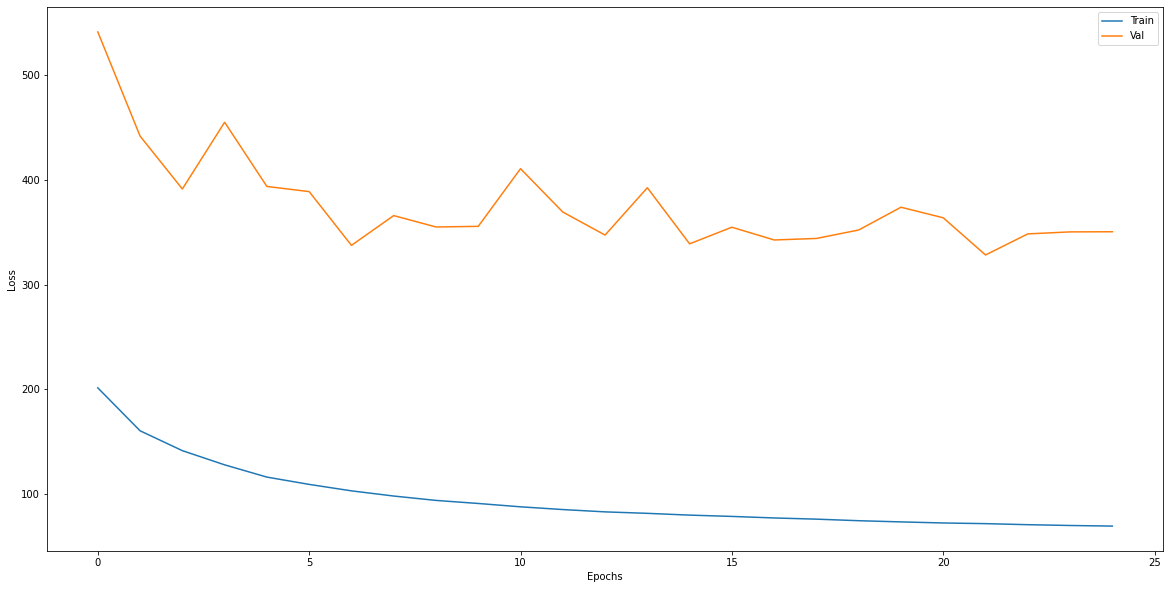

In [16]:
plt.figure(figsize=(20,10))

plt.plot(model.loss_during_training, label='Train')
plt.plot(model.valid_loss_during_training, label='Val')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

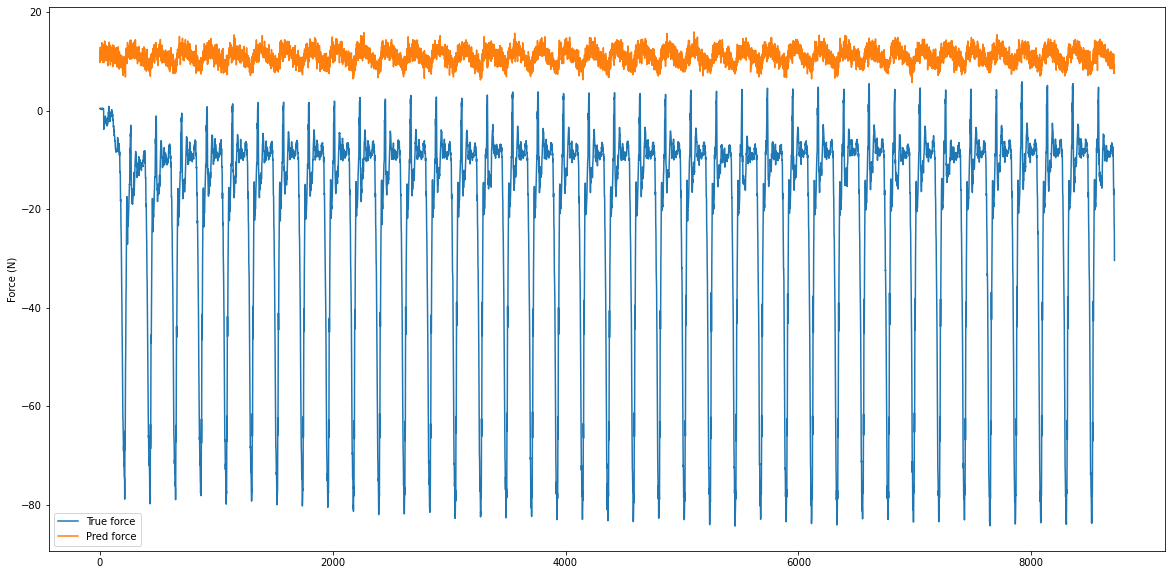

{'MAE': 30.535908, 'MSE': 1345.5004, 'R2': -2.030333110178898}




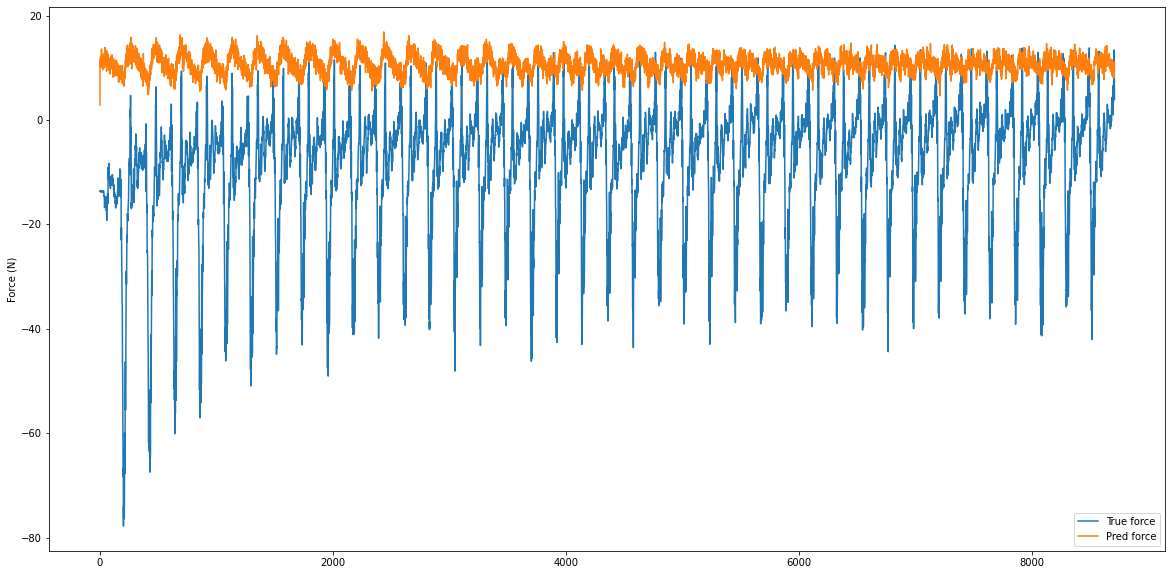

{'MAE': 19.076921, 'MSE': 494.69305, 'R2': -2.5366082324731285}




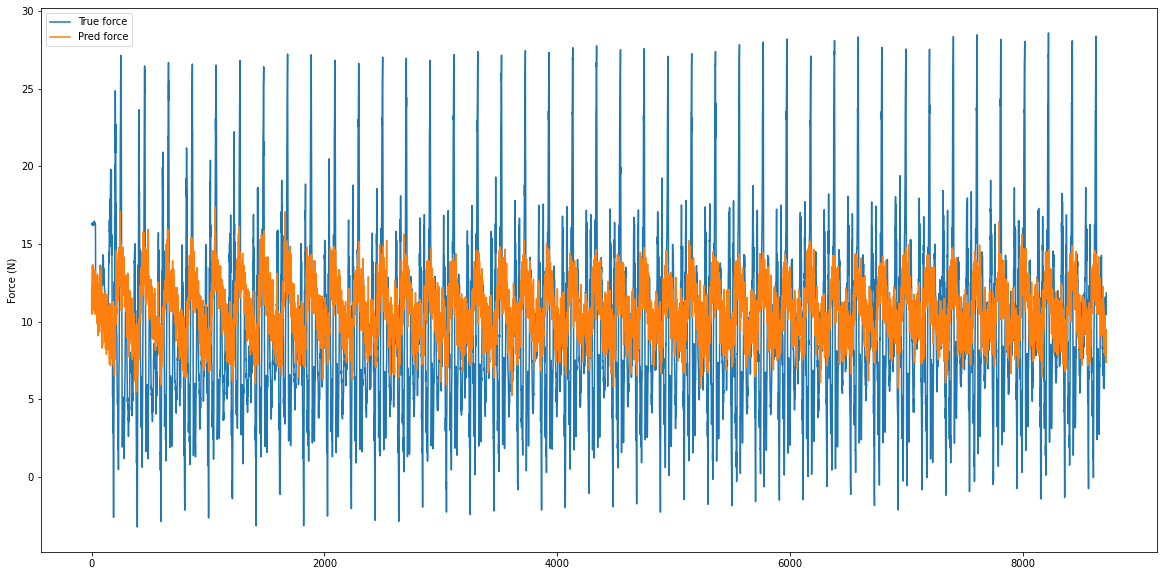

{'MAE': 4.5170636, 'MSE': 32.037834, 'R2': -0.11221665430411099}




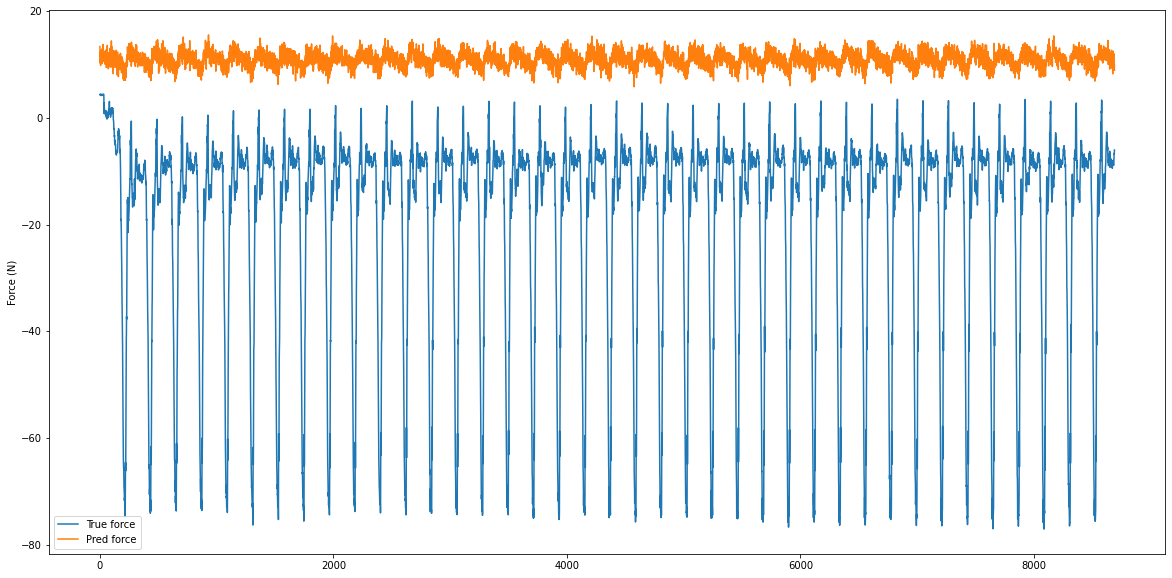

{'MAE': 29.225615, 'MSE': 1223.9775, 'R2': -2.076451520595083}




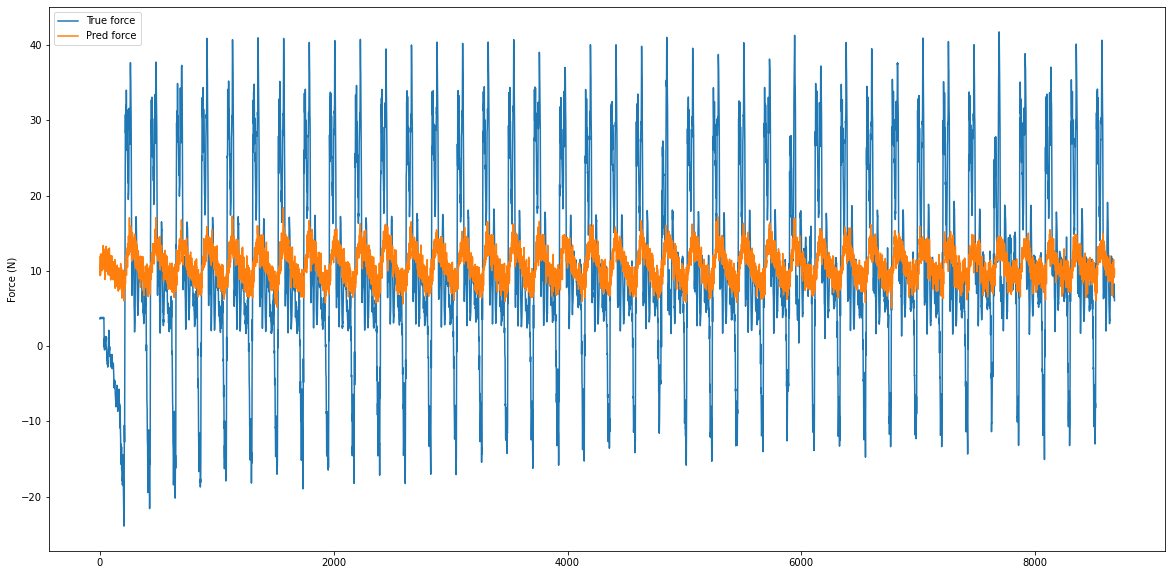

{'MAE': 8.369288, 'MSE': 120.75259, 'R2': 0.15237459695697275}




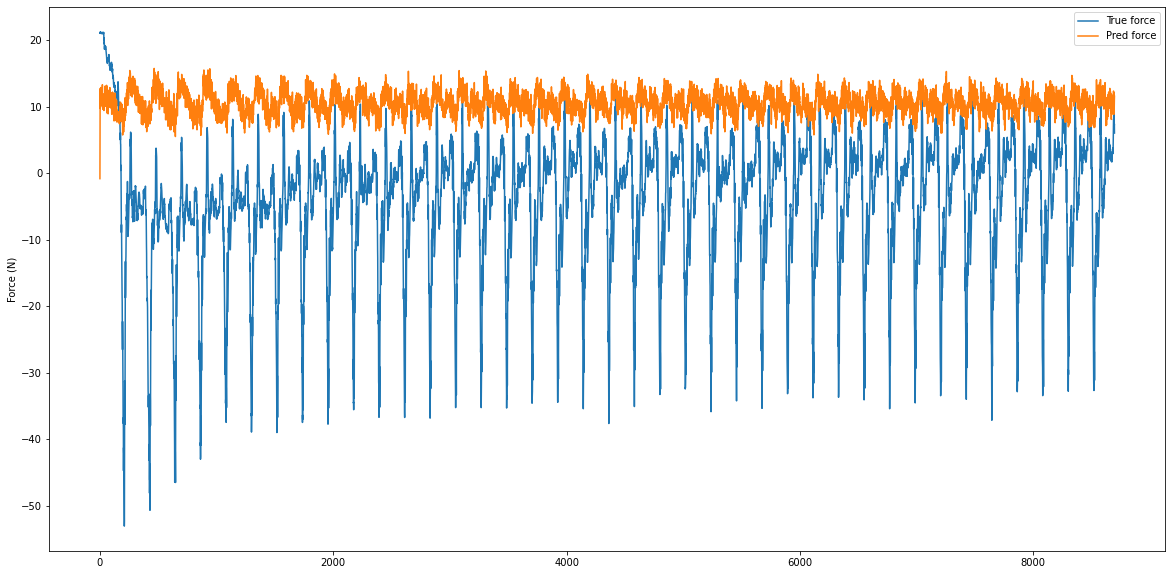

{'MAE': 14.509713, 'MSE': 293.66684, 'R2': -2.056720579024395}




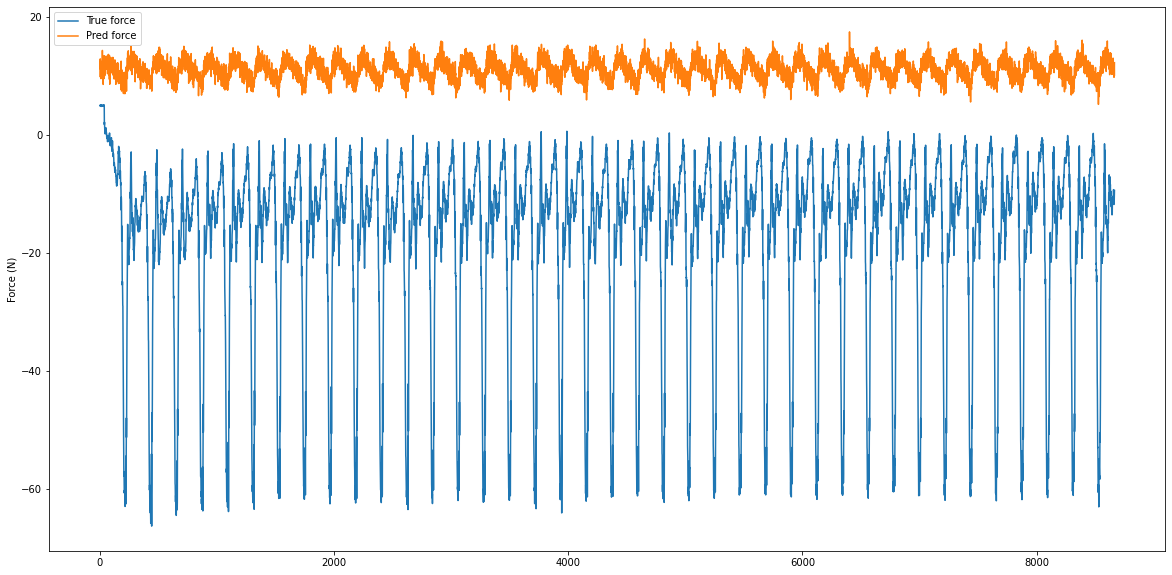

{'MAE': 28.687422, 'MSE': 1060.4696, 'R2': -3.1299050409277713}




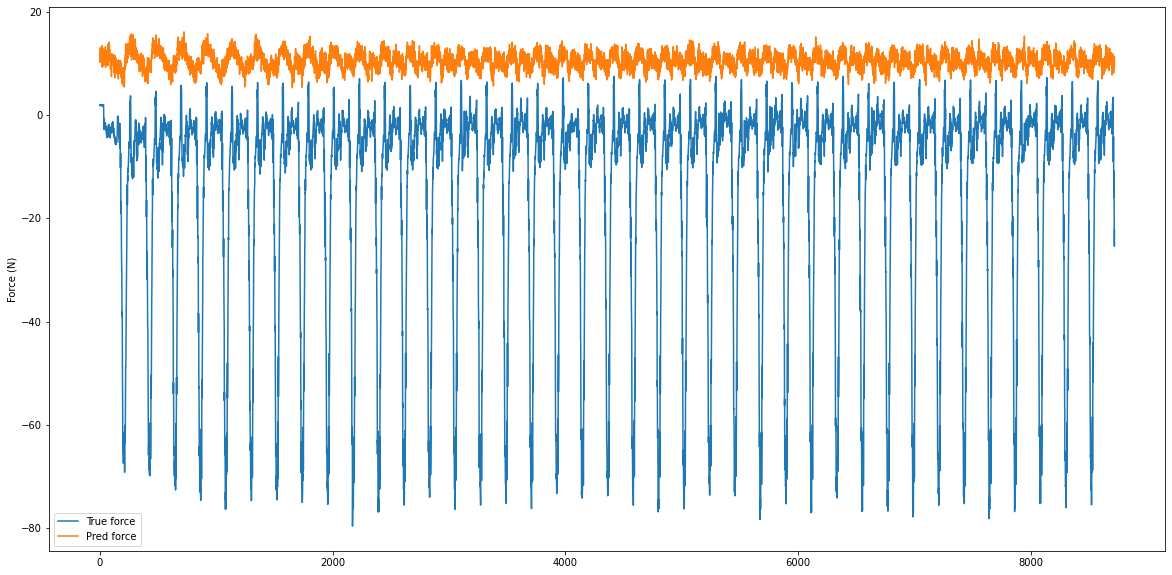

{'MAE': 24.317835, 'MSE': 1035.7966, 'R2': -1.2310179060527782}




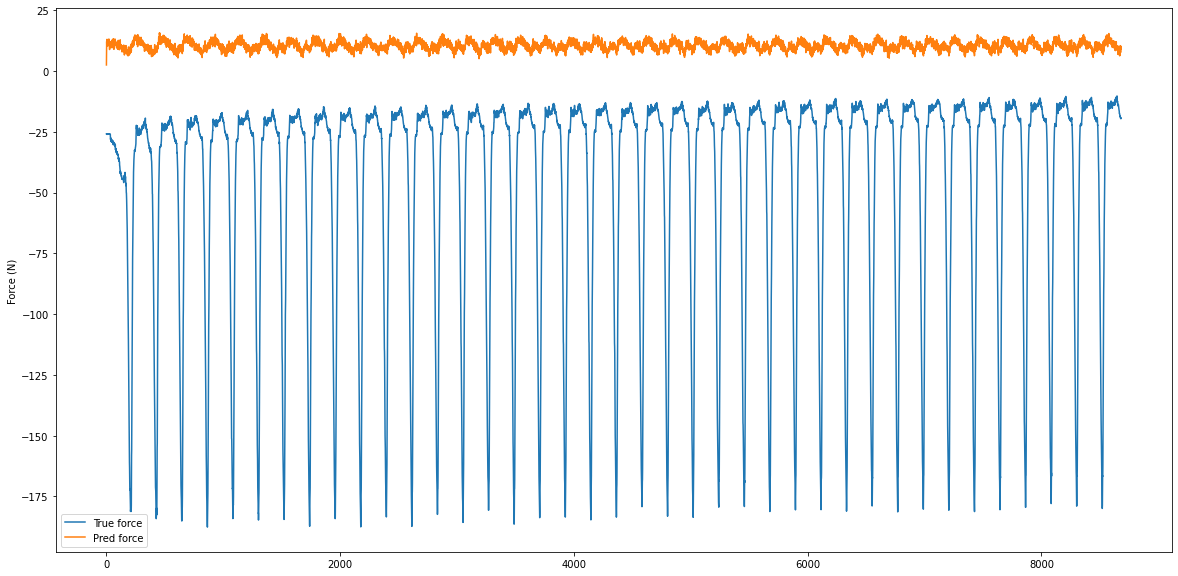

{'MAE': 53.33547, 'MSE': 4898.5996, 'R2': -1.3319263036688658}




In [17]:
all_results = {}

for i in test_experiments:
    X_aux = features_dict[i]
    Y_aux = targets_dict[i]
    
    true = []
    pred = []

    for i in range(SEQUENCE_LEN, X_aux.shape[0]):
        X_aux_ = X_aux[np.newaxis, i-SEQUENCE_LEN:i, :]
        for f in range(len(features)):
            s = scalers[f]

            X_aux_[:, :, f] = s.transform(X_aux_[:, :, f])
                
        features_ = torch.Tensor(X_aux_).to(TORCH_DEVICE)
        target_ = torch.Tensor(Y_aux[np.newaxis, i, force:force+1]).to(TORCH_DEVICE)

        out, hid = model.forward(features_)

        true.append(target_[:, 0].cpu().detach().numpy())
        pred.append(out[:, -1, 0].cpu().detach().numpy())

    plt.figure(figsize=(20,10))

    plt.plot(true, label='True force')
    plt.plot(pred, label='Pred force')

    plt.legend()
    plt.ylabel('Force (N)')
    plt.show()
    
    results = {
        'MAE': mean_absolute_error(true, pred),
        'MSE': mean_squared_error(true, pred),
        'R2': r2_score(true, pred)
    }

    all_results[i] = results
    
    print(results)
    print('\n')

In [18]:
results_summary = defaultdict(list)

for k, v in all_results.items():
    results_summary['MAE'].append(v['MAE'])
    results_summary['MSE'].append(v['MSE'])
    results_summary['R2'].append(v['R2'])
    
print('Mean MAE: {}'.format(np.mean(results_summary['MAE'])))
print('Median MAE: {}'.format(np.median(results_summary['MAE'])))
print('STD MAE: {}'.format(np.std(results_summary['MAE'])))
    
print('Mean MSE: {}'.format(np.mean(results_summary['MSE'])))
print('Median MSE: {}'.format(np.median(results_summary['MSE'])))
print('STD MSE: {}'.format(np.std(results_summary['MSE'])))

print('Mean R2: {}'.format(np.mean(results_summary['R2'])))
print('Median R2: {}'.format(np.median(results_summary['R2'])))
print('STD R2: {}'.format(np.std(results_summary['R2'])))

Mean MAE: 22.75491714477539
Median MAE: 21.697378158569336
STD MAE: 14.299274444580078
Mean MSE: 1144.999267578125
Median MSE: 765.244873046875
STD MSE: 1481.1419677734375
Mean R2: -1.5403089550111448
Median R2: -1.6943234413466304
STD R2: 1.0675478497161133
